이 노트북은 [케라스 창시자에게 배우는 딥러닝 2판](https://tensorflow.blog/kerasdl2/)의 예제 코드를 담고 있습니다.

<table align="left">
    <tr>
        <td>
            <a href="https://colab.research.google.com/github/rickiepark/deep-learning-with-python-2nd/blob/main/chapter12_part05_gans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
        </td>
    </tr>
</table>

## 생성적 적대 신경망 소개

### GAN 구현 방법

### 훈련 방법

### CelebA 데이터셋 준비하기

**CelebA 데이터 다운로드**

로컬에서 실행하는 경우 `pip install gdown` 명령으로 gdown 패키지를 먼저 설치해 주세요.

In [ ]:
!pip install -U gdown
!mkdir celeba_gan
!gdown 1up5bN8LCE2vHigVY-Z9yY2_aKRW5jN_9 -O celeba_gan/data.zip
!unzip -qq celeba_gan/data.zip -d celeba_gan

--2023-11-06 02:14:55--  https://drive.google.com/uc?id=1up5bN8LCE2vHigVY-Z9yY2_aKRW5jN_9&confirm=t
Resolving drive.google.com (drive.google.com)... 142.251.31.102, 142.251.31.139, 142.251.31.113, ...
Connecting to drive.google.com (drive.google.com)|142.251.31.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-04-a4-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/te0d7u3hm5hf75j7guf9gbmg7b51a82e/1699236825000/10613826186492816817/*/1up5bN8LCE2vHigVY-Z9yY2_aKRW5jN_9?uuid=3a3a212b-37eb-490c-bbc9-114c4253dfc3 [following]
--2023-11-06 02:14:56--  https://doc-04-a4-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/te0d7u3hm5hf75j7guf9gbmg7b51a82e/1699236825000/10613826186492816817/*/1up5bN8LCE2vHigVY-Z9yY2_aKRW5jN_9?uuid=3a3a212b-37eb-490c-bbc9-114c4253dfc3
Resolving doc-04-a4-docs.googleusercontent.com (doc-04-a4-docs.googleusercontent.com)... 108.177.126.132, 2a00:1450:4013:c01::84
Connectin

**이미지 디렉토리에서 데이터셋을 만듭니다**

In [ ]:
from tensorflow import keras
dataset = keras.utils.image_dataset_from_directory(
    "celeba_gan",
    label_mode=None,
    image_size=(64, 64),
    batch_size=32,
    smart_resize=True)

Found 202599 files belonging to 1 classes.


**픽셀 값 범위 바꾸기**

In [ ]:
dataset = dataset.map(lambda x: x / 255.)

**첫 번째 이미지 출력하기**

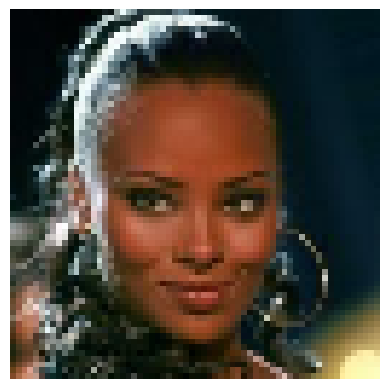

In [ ]:
import matplotlib.pyplot as plt
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

### 판별자

**GAN 판별자 네트워크**

In [ ]:
from tensorflow.keras import layers

discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)

In [ ]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         262272    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)            

### 생성자

**GAN 생성자 네트워크**

In [ ]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)

In [ ]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8192)              1056768   
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 16, 16, 128)       262272    
 anspose)                                                        
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 32, 32, 256)       524544    
 Transpose)                                                      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 256)       0 

### 적대 네트워크

**GAN 모델**

In [ ]:
import tensorflow as tf
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim))
        generated_images = self.generator(random_latent_vectors)
        combined_images = tf.concat([generated_images, real_images], axis=0)
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))],
            axis=0
        )
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim))

        misleading_labels = tf.zeros((batch_size, 1))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(
                self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(
            zip(grads, self.generator.trainable_weights))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {"d_loss": self.d_loss_metric.result(),
                "g_loss": self.g_loss_metric.result()}

**훈련 과정 동안에 이미지를 생성하기 위한 콜백**

In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.utils.array_to_img(generated_images[i])
            img.save(f"generated_img_{epoch:03d}_{i}.png")

**GAN 모델 컴파일하고 훈련하기**

In [ ]:
# 코랩에서 정상 실행만 확인하기 위해 에포크 횟수를 10으로 줄입니다
epochs = 10 # 100

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

Epoch 1/10
6332/6332 [==============================] - 491s 75ms/step - d_loss: 0.6046 - g_loss: 1.2332
Epoch 2/10
6332/6332 [==============================] - 477s 75ms/step - d_loss: 0.6568 - g_loss: 1.0202
Epoch 3/10
6332/6332 [==============================] - 476s 75ms/step - d_loss: 0.6610 - g_loss: 1.0107
Epoch 4/10
6332/6332 [==============================] - 476s 75ms/step - d_loss: 0.6521 - g_loss: 1.0308
Epoch 5/10
6332/6332 [==============================] - 476s 75ms/step - d_loss: 0.6583 - g_loss: 1.0028
Epoch 6/10
6332/6332 [==============================] - 476s 75ms/step - d_loss: 0.6472 - g_loss: 0.9985
Epoch 7/10
6332/6332 [==============================] - 478s 75ms/step - d_loss: 0.6675 - g_loss: 0.9549
Epoch 8/10
6332/6332 [==============================] - 478s 75ms/step - d_loss: 0.6771 - g_loss: 0.9296
Epoch 9/10
6332/6332 [==============================] - 477s 75ms/step - d_loss: 0.6718 - g_loss: 0.9296
Epoch 10/10
6332/6332 [==============================] 

### 정리

## 요약